## 06. 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷

### 규제 선형 모델의 개요

비용 함수 목표 = Min(RSS(W) + alpha * W^2)
- alpha 값을 크게: 비용 함수는 회귀 계수 W의 값을 작게 해 과적합을 개선 할 수 있음(RSS(W) 최소화)
- alpha 값을 작게: 회귀 계속 W의 값이 커져도 어느 정도 상쇄가 가능하므로 학습 데이터 적합을 더 개선할 수 있음

규제
- L2 규제: alpha * W^2와 같이 W의 제곱에 대해 패널티를 부여하는 방식 (릿지 회귀)
- L1 규제: alpha * W와 같이 W의 절댓값에 대해 패널티를 부여하는 방식 (라쏘 회귀)

### 릿지 회귀

In [3]:
import pandas as pd
import numpy as np

# 현재는 보스턴 데이터셋의 윤리적인 문제로 삭제되어 따로 생성
data_url = "http://lib.stat.cmu.edu/datasets/boston"
columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','PRICE']
bostonDF = pd.read_csv('boston.txt',sep='\s+',header=None)
bostonDF.columns=columns

print('Boston 데이터 세트 크기 :', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3,
                                                   random_state=156)

In [6]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# alpha=10으로 설정해 릿지 회귀 수행.
# alpha는 릿지 회귀의 alpha L2 규제 계수
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores,3))
print(' 5 folds 의 개별 RMSE scores: ', np.round(rmse_scores,3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
 5 folds 의 개별 RMSE scores:  [3.38  4.929 5.305 8.637 5.34 ]
 5 folds 의 평균 RMSE : 5.518 


앞에서 규제가 없던 LinearRegression RMSE 평균보다 뛰어난 예측 성능 보여줌

In [8]:
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함.
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    
    # cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 5.829
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330


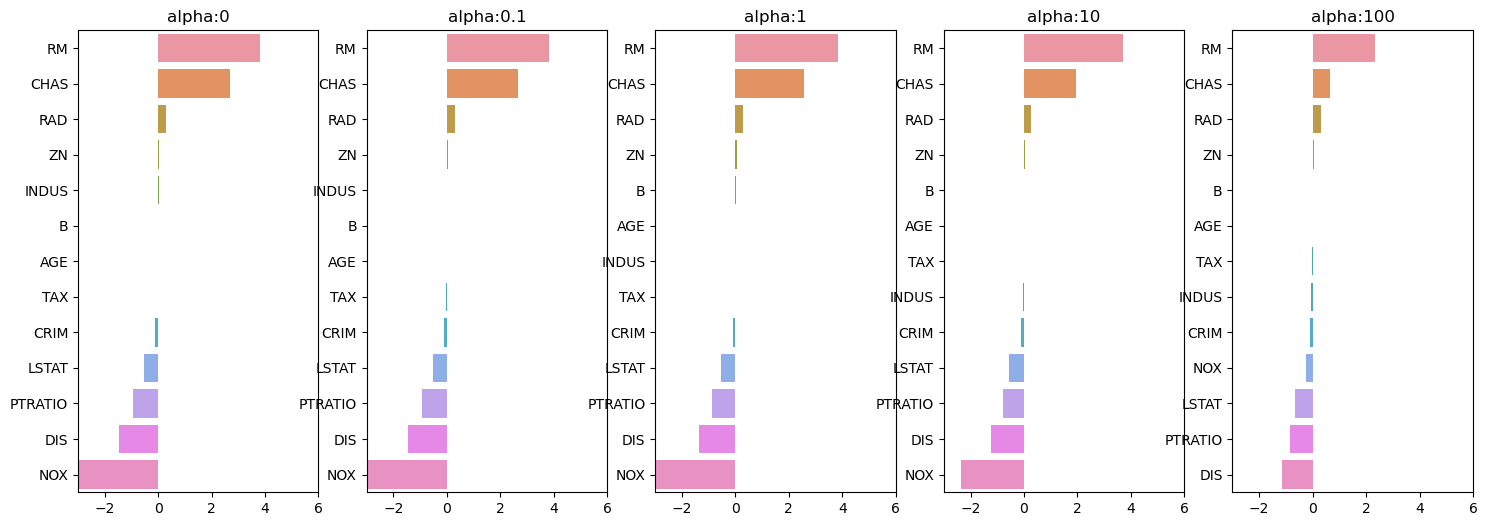

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize=(18,6), nrows=1, ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_data, y_target)
    # alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가.
    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])
    
# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

In [12]:
# DataFrame에 저장된 alpha 값의 변화에 따른 릿지 회귀 계수 값
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


alpha 값이 증가하면서 회귀 계수가 지속적으로 작아지고 있음

그러나 릿지 회귀는 회귀 계수를 0으로 만들지는 않음

### 라쏘 회귀
- L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거
- 적절한 피처만 회귀에 포함시키는 피처 선택의 특성

In [1]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
    coeff_df = pd.DataFrame()
    if verbose : print('######', model_name, '######')
    for param in params:
        if model_name =='Ridge':model = Ridge(alpha=param)
        elif model_name =='Lasso':model = Lasso(alpha=param)
        elif model_name =='ElasticNet':model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n,
                                        scoring='neg_mean_squared_error', cv=5)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        model.fit(X_data, y_target)
        # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가.
        coeff = pd.Series(data=model.coef_, index=X_data.columns)
        colname='alpha:'+str(param)
        coeff_df[colname]=coeff
    return coeff_df

# end of get_linear_regre_eval

In [14]:
# 라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n = X_data, y_target_n = y_target)

###### Lasso ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189


In [15]:
# 반환된 coeff_lasso_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


### 엘라스틱넷 회귀
- L2 규제와 L1 규제를 결합한 회귀
- 라쏘 회귀가 서로 상관관계가 높은 피처들의 경우에 이들 중에서 중요 피러만을 셀렉션하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 경향이 강함
- 수행시간이 상대적으로 오래 걸림

In [7]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [0.07,0.1,0.5,1,3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas,
                                      X_data_n=X_data, y_target_n=y_target)

###### ElasticNet ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068


In [8]:
# 반환된 coeff_elastic_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


### 선형 회귀 모델을 위한 데이터 변환
- 피처값과 타깃값의 분포가 정규 분포인 것을 선호
- 중요 피처들이나 타깃값의 분포도가 심하게 왜곡된 경우 스케일링/정규화 작업 수행 필요

1. StandardScaler 클래스 / MinMaxScaler 클래스
2. 1번으로 예측 성능 향상이 없는 경우 3번 실행
3. 로그 변환(Log Transformation)

In [19]:
# 언더플로우 발생 방지를 위해 1+log()인 np.loglp() 사용
# method는 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다항식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method=='Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method=='Minmax':
        scaled_data = MinMaxscaler().fit_transform(input_data)
    elif method=='Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data=input_data
    
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree,
                                        include_bias=False).fit_transform(scaled_data)
    
    return scaled_data

In [20]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출.
alphas = [0.1,1,10,100]

# 5개 방식으로 변환. 먼저 원본 그대로, 표준정규 분포, 표준정규 분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods=[(None, None),('Standard',None),('Standard',2),
             ('MinMax',None), ('MinMax',2),('Log',None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1],
                                   input_data = X_data)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n = X_data_scaled,
                       y_target_n=y_target, verbose=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 9.141
alpha 1일 때 5 폴드 세트의 평균 RMSE: 8.938
alpha 10일 때 5 폴드 세트의 평균 RMSE: 10.556
alpha 100일 때 5 폴드 세트의 평균 RMSE: 10.566

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 4.7

로그 변환을 했을 때 0.1, 1, 10인 경우 모두 좋은 성능 향상이 나타남

## 07. 로지스틱 회귀
- 선형 회귀 방식을 분류에 적용한 알고리즘
- 시그모이드 함수 최적선을 찾고 이 시그모이드 함수의 반환 값을 확률로 간주해 확률에 따라 분류를 결정

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer=load_breast_cancer()

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target,
                                                   test_size=0.3, random_state=0)

In [23]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용해 학습 및 예측 수행.
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

# 정확도와 roc_auc 측정
print('accuracy: {:0.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_test, lr_preds)))

accuracy: 0.977
roc_auc: 0.972


LogisticRegression 클래스의 주요 하이퍼 파라미터
- penalty(규제의 유형)

> l2: L2 규제(기본)

> l1: L1 규제
- C: 규제 강도를 조절하는 alpha값의 역수(작을 수록 규제 강도가 큼)

In [25]:
from sklearn.model_selection import GridSearchCV

params = {'penalty':['l2','l1'],
         'C':[0.01, 0.1, 1, 1, 5, 10]}

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_,
                                                 grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 1, 'penalty': 'l2'}, 최적 평균 정확도:0.975


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

## 08. 회귀 트리
- 회귀를 위한 트리를 생성하고 이를 기반으로 회귀 예측을 하는 것
- 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값 계산 (cf. 분류 트리: 특정 클래스 레이블을 결정)

In [4]:
# RandomForestRegressor

from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# 보스턴 데이터 세트 로드
data_url = "http://lib.stat.cmu.edu/datasets/boston"
columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','PRICE']
bostonDF = pd.read_csv('boston.txt',sep='\s+',header=None)
bostonDF.columns=columns

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring='neg_mean_squared_error',cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores,2))
print(' 5 교차 검증의 개별 RMSE scores: ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))

 5 교차 검증의 개별 Negative MSE scores:  [ -7.88 -13.14 -20.57 -46.23 -18.88]
 5 교차 검증의 개별 RMSE scores:  [2.81 3.63 4.54 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.423


In [5]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('#####', model.__class__.__name__,'#####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

##### DecisionTreeRegressor #####
 5 교차 검증의 평균 RMSE : 5.978
##### RandomForestRegressor #####
 5 교차 검증의 평균 RMSE : 4.423
##### GradientBoostingRegressor #####
 5 교차 검증의 평균 RMSE : 4.269
##### XGBRegressor #####
 5 교차 검증의 평균 RMSE : 4.251
##### LGBMRegressor #####
 5 교차 검증의 평균 RMSE : 4.646


<AxesSubplot:>

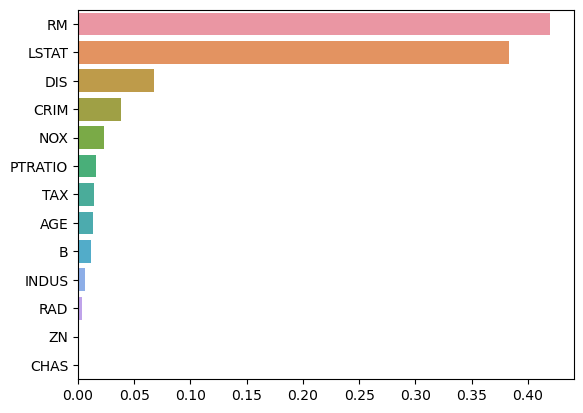

In [10]:
# 선형 회귀와 다른 처리 방식이므로 coef_ 속성이 없음
# feature_importances_를 이용해 피처별 중요도를 알 수 있음

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 세트를 적용해 학습합니다.
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

(100, 2)


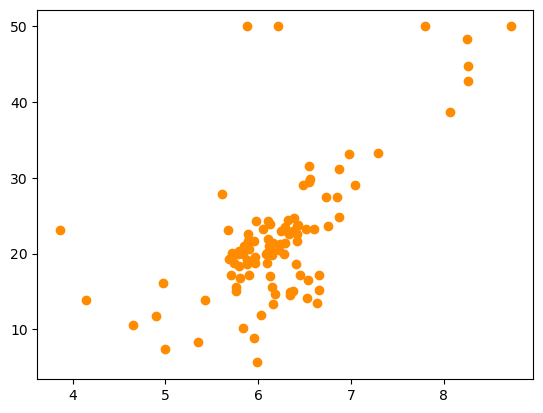

In [11]:
bostonDF_sample = bostonDF[['RM','PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100, random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')

In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2,7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 세트를 4.5~8.5까지의 100개 데이터 세트로 생성.
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1,1)

# 보스턴 주택 가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# 학습과 예측 수행.
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

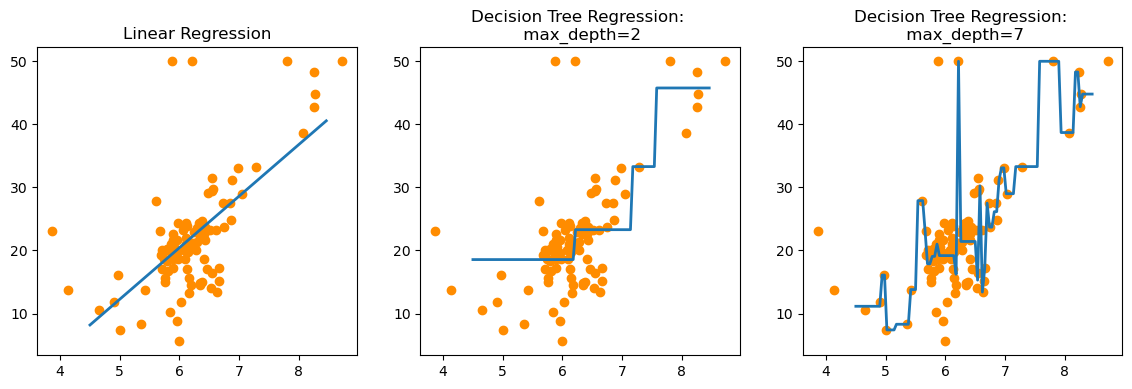

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

# X 축 값을 4.5~8.5로 변환하며 입력했을 때 선형 회귀와 결정 트리 회귀 예측선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax1.plot(X_test, pred_lr, label='linear', linewidth=2)

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선
ax2.set_title('Decision Tree Regression: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax2.plot(X_test, pred_rf2, label='max_depth:3', linewidth=2)

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax3.plot(X_test, pred_rf7, label='max_depth:7', linewidth=2)

2,3번째인 회귀 트리의 경우 분할되는 데이터 지점에 따라 브랜치를 만들면서 계단 형태로 회귀선을 만듦.

DecisionTreeRegressor의 max_depth=7인 경우에는 학습 데이터 세트의 이상치 데이터도 학습하면서 복잡한 계단 형태의 회귀선을 만들어 과적합이 되기 쉬운 모델이 되었음